### Импортируем библиотеки

In [224]:
# Обработка изображений
import cv2
import importlib
import os
import tensorflow as tf
# Линейная алгебра
import numpy as np

# Графики
from matplotlib import pyplot as plt
from IPython.display import Image


# в режиме редактирования сбрасуем кэшь иначе не видно изменений
imported_module = importlib.import_module("settings")
importlib.reload(imported_module)
imported_module = importlib.import_module("utils")
importlib.reload(imported_module)
imported_module = importlib.import_module("model")
importlib.reload(imported_module)

import settings
import utils
from model import YoloV3, YoloLoss


from tensorflow.keras.callbacks import (
    ReduceLROnPlateau,
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard
)
# Работаем с фреймворком Keras и Tensorflow
from tensorflow.python.client import device_lib



In [179]:
print(device_lib.list_local_devices())
tf.config.set_visible_devices([], 'GPU')

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 786509722821547829
xla_global_id: -1
]


## Загрузка данных

In [ ]:
!wget https://storage.yandexcloud.net/academy.ai/CV/chess_yolo.zip

In [ ]:
!unzip -qo "chess_yolo.zip"

In [3]:
!ls chess_yolo

data.yaml	    README.roboflow.txt  train	video.mp4
README.dataset.txt  test		 valid


In [4]:
!cat $settings.yaml_path

path: ../chess_yolo

train: train/images
val: valid/images
test: test/images

names: 
  0: слон
  1: черный слон
  2: черный король
  3: черный конь
  4: черная пешка
  5: черный ферзь
  6: черная ладья
  7: белый слон
  8: белый король
  9: белый конь
  10: белая пешка
  11: белый ферзь
  12: белая ладья

## Подготавливаем датасет

In [115]:
train_ds = utils.load_yolo_dataset(
    "./chess_yolo/train/images",
    "./chess_yolo/train/labels",
    img_size=settings.SIZE,
    max_boxes=20
)
train_ds = train_ds.shuffle(buffer_size=512)
train_ds = train_ds.batch(settings.BATCH_SIZE)
train_ds = train_ds.map(lambda x, y: (
    utils.preprocess_image(x, settings.SIZE),
    utils.transform_targets(y, settings.YOLO_ANCHORS, settings.YOLO_ANCHOR_MASKS, settings.SIZE)))
train_ds = train_ds.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________
(4,)
int64
________


In [58]:
val_ds = utils.load_yolo_dataset(
    "./chess_yolo/valid/images",
    "./chess_yolo/valid/labels",
    img_size=settings.SIZE,
    max_boxes=20
)
val_ds = val_ds.shuffle(buffer_size=512)
val_ds = val_ds.batch(settings.BATCH_SIZE)
val_ds = val_ds.map(lambda x, y: (
    utils.preprocess_image(x, settings.SIZE),
    utils.transform_targets(y, settings.YOLO_ANCHORS, settings.YOLO_ANCHOR_MASKS, settings.SIZE)))
val_ds = val_ds.prefetch(
    buffer_size=tf.data.experimental.AUTOTUNE)

## Обучаем модель

In [2]:
checkpoint = 'checkpoints/yolov3_train_{epoch}.weights.h5'

In [73]:
yolo = YoloV3(classes=settings.NUM_CLASSES, training=True)
yolo.load_weights(checkpoint.format(epoch=5))

In [51]:
# проходи по трём головам и делаем функции потери для каждого
loss = [YoloLoss(settings.YOLO_ANCHORS[mask], classes=settings.NUM_CLASSES)
            for mask in settings.YOLO_ANCHOR_MASKS]


In [74]:
optimizer = tf.keras.optimizers.Adam(learning_rate=1.5e-4)

In [75]:
yolo.compile(optimizer=optimizer, loss=loss, run_eagerly=True)

In [54]:
callbacks = [
            ReduceLROnPlateau(verbose=1),
            EarlyStopping(patience=3, verbose=1),
            ModelCheckpoint(checkpoint,
                            verbose=1, save_weights_only=True),
            TensorBoard(log_dir='logs')
        ]

In [59]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=5
)

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 200.8826 - yolo_output_1_loss: 6.2868 - yolo_output_2_loss: 64.2670 - yolo_output_3_loss: 118.6359 
Epoch 1: saving model to checkpoints/yolov3_train_1.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 946s 12s/step - loss: 165.4346 - yolo_output_1_loss: 2.4599 - yolo_output_2_loss: 55.9942 - yolo_output_3_loss: 95.2889 - val_loss: 126.9848 - val_yolo_output_1_loss: 4.0067 - val_yolo_output_2_loss: 41.2463 - val_yolo_output_3_loss: 70.0485 - learning_rate: 1.5000e-04
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 102.0231 - yolo_output_1_loss: 0.4013 - yolo_output_2_loss: 36.5884 - yolo_output_3_loss: 53.3591 
Epoch 2: saving model to checkpoints/yolov3_train_2.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 962s 13s/step - loss: 95.9315 - yolo_output_1_loss: 0.3824 - yolo_output_2_loss: 36.5896 - yolo_output_3_loss: 47.2907 - val_loss: 3396.2578 - val_yolo_output_1_loss: 1.7833 - val_yolo_output_2_loss: 1850.2085 - val_yolo_output_3_loss: 1

In [69]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=5
)

Epoch 1/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 12s/step - loss: 44.2523 - yolo_output_1_loss: 0.0926 - yolo_output_2_loss: 18.9346 - yolo_output_3_loss: 13.7369 
Epoch 1: saving model to checkpoints/yolov3_train_1.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 919s 12s/step - loss: 37.2291 - yolo_output_1_loss: 0.0500 - yolo_output_2_loss: 15.3497 - yolo_output_3_loss: 10.4530 - val_loss: 27.4030 - val_yolo_output_1_loss: 0.0224 - val_yolo_output_2_loss: 9.9893 - val_yolo_output_3_loss: 6.2791 - learning_rate: 1.5000e-04
Epoch 2/5
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 14s/step - loss: 26.6853 - yolo_output_1_loss: 0.0103 - yolo_output_2_loss: 9.5506 - yolo_output_3_loss: 6.1543 
Epoch 2: saving model to checkpoints/yolov3_train_2.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 1105s 15s/step - loss: 25.9336 - yolo_output_1_loss: 0.0090 - yolo_output_2_loss: 9.4407 - yolo_output_3_loss: 5.6539 - val_loss: 24.1786 - val_yolo_output_1_loss: 0.0132 - val_yolo_output_2_loss: 8.8408 - val_yolo_output_3_loss: 4.7814 - learnin

In [76]:
history = yolo.fit(
    train_ds,
    validation_data=val_ds,
    callbacks=callbacks,
    epochs=40
)

Epoch 1/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 19.8493 - yolo_output_1_loss: 0.0023 - yolo_output_2_loss: 8.0321 - yolo_output_3_loss: 2.7140 
Epoch 1: saving model to checkpoints/yolov3_train_1.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 882s 12s/step - loss: 16.4355 - yolo_output_1_loss: 0.0012 - yolo_output_2_loss: 5.4294 - yolo_output_3_loss: 2.0212 - val_loss: 19.8330 - val_yolo_output_1_loss: 9.4096e-04 - val_yolo_output_2_loss: 7.4862 - val_yolo_output_3_loss: 3.6137 - learning_rate: 1.5000e-04
Epoch 2/40
76/76 ━━━━━━━━━━━━━━━━━━━━ 0s 11s/step - loss: 12.4210 - yolo_output_1_loss: 0.0028 - yolo_output_2_loss: 2.8618 - yolo_output_3_loss: 0.9390 
Epoch 2: saving model to checkpoints/yolov3_train_2.weights.h5
76/76 ━━━━━━━━━━━━━━━━━━━━ 888s 12s/step - loss: 12.4282 - yolo_output_1_loss: 0.0463 - yolo_output_2_loss: 2.9171 - yolo_output_3_loss: 0.9564 - val_loss: 97.2361 - val_yolo_output_1_loss: 78.5329 - val_yolo_output_2_loss: 7.6455 - val_yolo_output_3_loss: 2.7512 - learn

## Эксперименты

In [3]:
yolo = YoloV3(classes=settings.NUM_CLASSES)

2025-08-25 10:05:43.021276: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-08-25 10:05:43.021293: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:178] verbose logging is disabled. Rerun with verbose logging (usually --v=1 or --vmodule=cuda_diagnostics=1) to get more diagnostic output from this module
2025-08-25 10:05:43.021297: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:183] retrieving CUDA diagnostic information for host: sergey
2025-08-25 10:05:43.021299: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:190] hostname: sergey
2025-08-25 10:05:43.021354: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:197] libcuda reported version is: 535.261.3
2025-08-25 10:05:43.021365: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:201] kernel reported version is: 535.261.3
2025-08

In [4]:
yolo.load_weights(checkpoint.format(epoch=3))

In [229]:
#image, label = utils.get_random_image_label()
#real_image = utils.draw_yolo_labels(image, label, class_names)
#plt.imshow(real_image)
#!cat $label
#Image(filename=image)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step


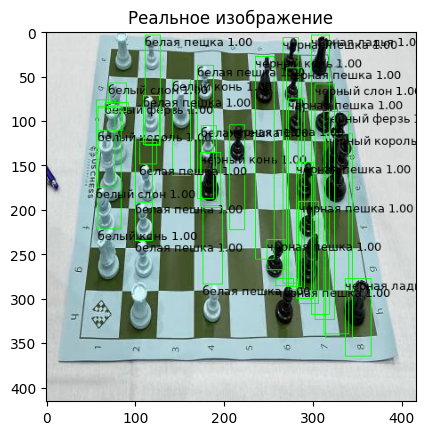

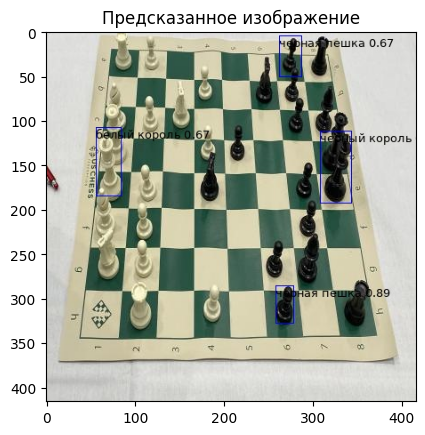

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 213ms/step


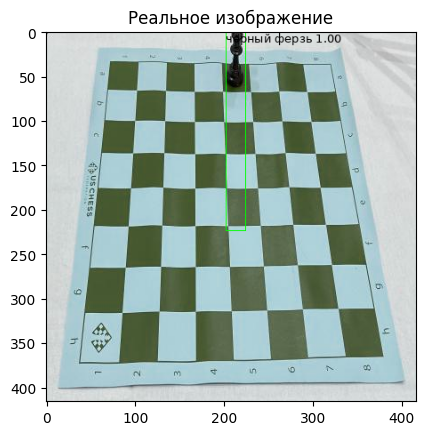

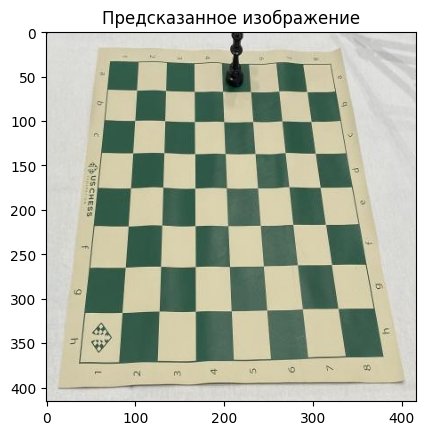

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


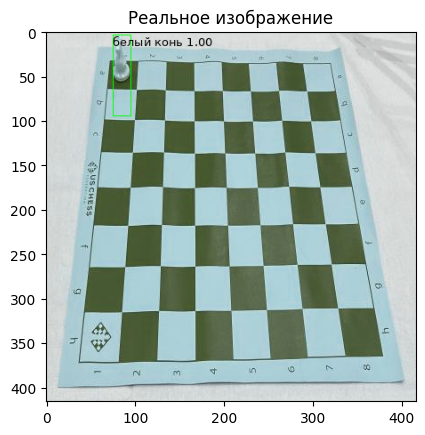

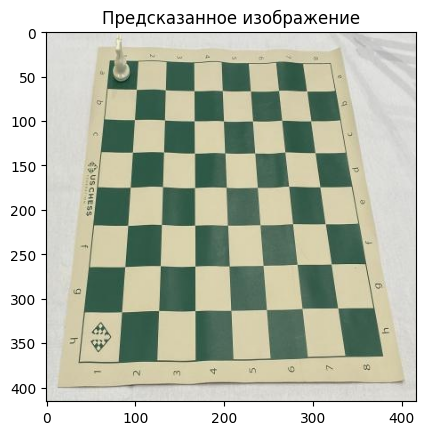

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 249ms/step


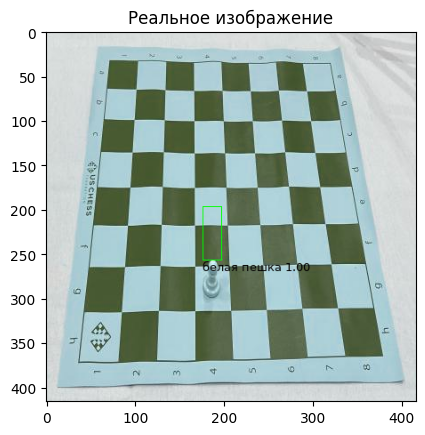

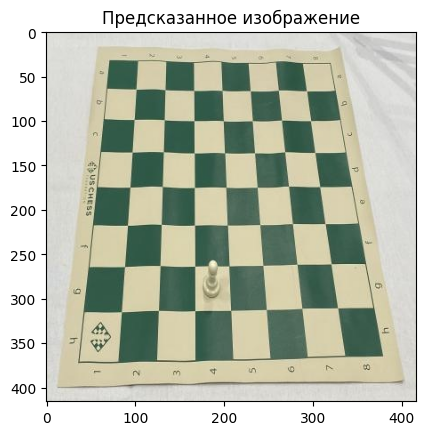

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 192ms/step


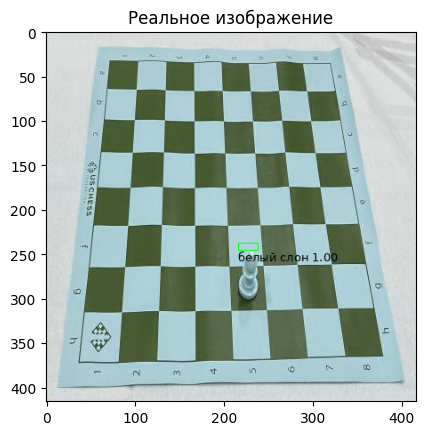

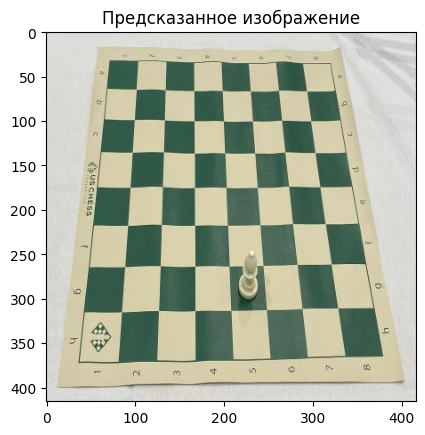

In [232]:
for _ in range(5):
    image, label = utils.get_random_image_label()
    class_names = list(settings.CLASS_NAMES.values())
    detected = utils.detect_objects(yolo, image, class_names)
    real_image = utils.draw_yolo_labels(image, label, class_names)
    plt.title("Реальное изображение")
    plt.imshow(real_image)
    plt.show()

    plt.title("Предсказанное изображение")
    plt.imshow(detected)
    plt.show()

### Вывод